In [1]:
import collections
import functools
import itertools
import math
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec, ticker
%matplotlib inline

import pandas as pd

import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()

import scipy
from scipy.interpolate import interp1d

import statsmodels.api as sm

from IPython.display import Image

In [3]:
def read_data(filename):
    """ Reads in raw photoemission spectra and performs initial transformation
        and cleaning.
    """
    data = pd.read_csv(filename, sep='[\t,]+', header=None, engine='python',
                       na_values=['XXX.XXX'], names=['nm', 'QE'])

    if data.nm.min() < 10.:                    # energy rather than wavelength, needs conversion
        data['E'] = data.nm
        data['nm'] = 1240. / data.E            # conversion of energy to wavelength
    else:
        data['E'] = 1240. / data.nm            # conversion of wavelength to energy

    data['QE'] = data.QE.clip_lower(0.)        # remove negative elements
    data['QE3'] = np.power(data.QE, 1. / 3.)   # QE^(1/3) so we can use a linear fit

    return data

In [4]:
class LinearFit(object):

    def __init__(self, x, y, fit):
        self.x = x
        self.X = sm.add_constant(x)
        self.y = y
        self.fit = fit

        self.b = fit.params
        self.y_intercept, self.slope = fit.params
        self.x_intercept = -self.y_intercept / self.slope

        self.xm = np.mean(x)
        self.Sxx = np.sum(np.power(self.x - self.xm, 2))
        self.ym = np.mean(y)
        self.n = fit.nobs
        self.dof = fit.df_resid
        self.rsquared = fit.rsquared
        self.stddev = np.sqrt(fit.ssr / fit.df_resid)

    def yp(self, xp):
        """Calculates line over given x range."""
        return np.dot(sm.add_constant(xp), self.b)

    def tstar(self, alpha):
        """Statistical t-test for confidence intervals."""
        return scipy.stats.distributions.t.ppf(1.0 - alpha / 2.0, self.dof)

    def confidence_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates confidence interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_ci(xp, alpha=alpha)
        if yp is not None:
            return self._x_ci(yp, alpha=alpha)

    def prediction_interval(self, xp=None, yp=None, alpha=0.05):
        """Calculates prediction interval for either x or y values."""
        if not (xp is None) ^ (yp is None):
            raise ValueError('Only one of [xp, yp] must be specified.')

        if xp is not None:
            return self._y_pi(xp, alpha=alpha)
        if yp is not None:
            return self._x_pi(yp, alpha=alpha)

    def plot_fit(self, xp, axis, alpha=0.05):
        """Plots the fit over given x range."""
        ci = self.confidence_interval(xp, alpha=alpha)
        pi = self.prediction_interval(xp, alpha=alpha)
        yp = self.yp(xp)

        axis.fill_between(xp, yp - pi, yp + pi, color='k', alpha=0.1)
        axis.fill_between(xp, yp - ci, yp + ci, color='k', alpha=0.2)
        axis.plot(xp, yp, c='k', ls=':')

    def _y_ci(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt((1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _y_pi(self, xp, alpha=0.05):
        return (self.tstar(alpha) * self.stddev
                * np.sqrt(1. + (1. / self.n) + (np.power(xp - self.xm, 2) / self.Sxx)))

    def _x_ci(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n)

        return np.array([(left - right) / denom, (left + right) / denom])

    def _x_pi(self, yp, alpha=0.05):
        """Inverse regression, after Sec 3.2 from Draper & Smith 1998."""
        xp = (yp - self.b[0]) / self.b[1]
        dx = xp - self.xm
        ts = self.tstar(alpha) * self.stddev
        b1 = self.b[1]
        g = (ts / b1) ** 2 / self.Sxx

        left = dx * g
        denom = (1. - g)
        right = (ts / b1) * np.sqrt(dx ** 2 / self.Sxx + denom / self.n + denom)

        return np.array([(left - right) / denom, (left + right) / denom])

## Read in Data

In [2]:
data_folder = '../data/raw/'

In [7]:
data = read_data(os.path.join(data_folder, 'ldbs1929_s0477b.txt'))

# Test Rolling Window Fit

In [17]:
window_length = 15

stats = {
    'i': [],
    'slope': [],
    'threshold': [],
    'r2': [],
    'stddev': [],
}
fits = []

n = (window_length - 1) // 2
for mid in range(n, len(data) - n):
    low, high = mid - n, mid + n + 1
    window = data.iloc[low:high]

    x = window.E.values
    X = sm.add_constant(x)
    y = window.QE3.values

    model = sm.OLS(y, X)
    results = model.fit()

    fit = LinearFit(x, y, results)

    fits.append(fit)
    stats['i'].append(mid)
    stats['slope'].append(fit.slope)
    stats['threshold'].append(fit.x_intercept)
    stats['r2'].append(fit.rsquared)
    stats['stddev'].append(fit.stddev)

stats = pd.DataFrame(stats)

# we are looking for the line with
#   a) the highest R^2
#   b) the highest slope

max_slope = stats.slope.max()
stats['best'] = stats.r2 + stats.slope / max_slope
maxima = scipy.signal.argrelmax(stats.best.values)[0]
best_fit = stats.iloc[maxima].best.idxmax()

f = fits[best_fit]

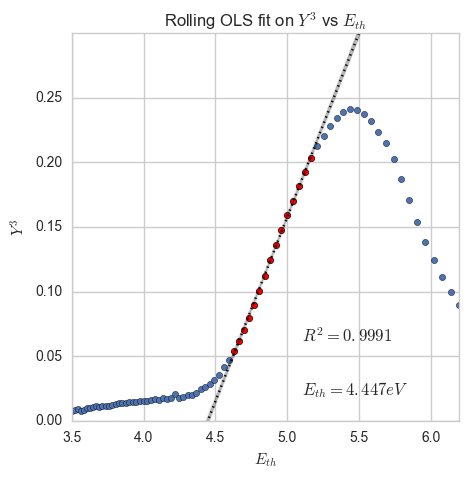

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(x='E', y='QE3', kind='scatter', ax=ax, xlim=(3.5, 6.2), ylim=(0, 0.3))

ax.scatter(f.x, f.y, c='r')
xp = np.arange(4, 6, 0.01)
f.plot_fit(xp, ax)
ax.text(5.1, 0.061, r'$R^2 = {:.4}$'.format(f.rsquared))
ax.text(5.1, 0.02, r'$E_{th}$' + r'$ = {:.4} eV$'.format(f.x_intercept))

ax.set_xlabel(r'$E_{th}$')
ax.set_ylabel(r'$Y^3$')
ax.set_title(r'Rolling OLS fit on $Y^3$ vs $E_{th}$')

plt.show()

# Converting to function
Comparing window sizes

In [34]:
def find_linear(df, window_length=15):
    """ Fits linear portion of spectra using a rolling mean of `window_length`
        and takes the n best fits as candidates.
    """
    if window_length % 2 == 0:
        raise ValueError('The window must be odd')
    if window_length < 5:
        raise ValueError('The window must be at least 5')

    stats = {
        'i': [],
        'slope': [],
        'threshold': [],
        'r2': [],
        'stddev': [],
    }
    fits = []

    n = (window_length - 1) // 2
    for mid in range(n, len(df) - n):
        low, high = mid - n, mid + n + 1
        window = df.iloc[low:high]

        x = window.E.values
        X = sm.add_constant(x)
        y = window.QE3.values

        model = sm.OLS(y, X)
        results = model.fit()

        fit = LinearFit(x, y, results)

        fits.append(fit)
        stats['i'].append(mid)
        stats['slope'].append(fit.slope)
        stats['threshold'].append(fit.x_intercept)
        stats['r2'].append(fit.rsquared)
        stats['stddev'].append(fit.stddev)

    stats = pd.DataFrame(stats)

    # we are looking for the line with
    #   a) the highest R^2
    #   b) the highest slope

    max_slope = stats.slope.max()
    stats['best'] = stats.r2 + stats.slope / max_slope
    maxima = scipy.signal.argrelmax(stats.best.values)[0]
    best_fit = stats.iloc[maxima].best.idxmax()

    return fits[best_fit]

/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1181: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/jmarini/.virtualenvs/photoemission/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


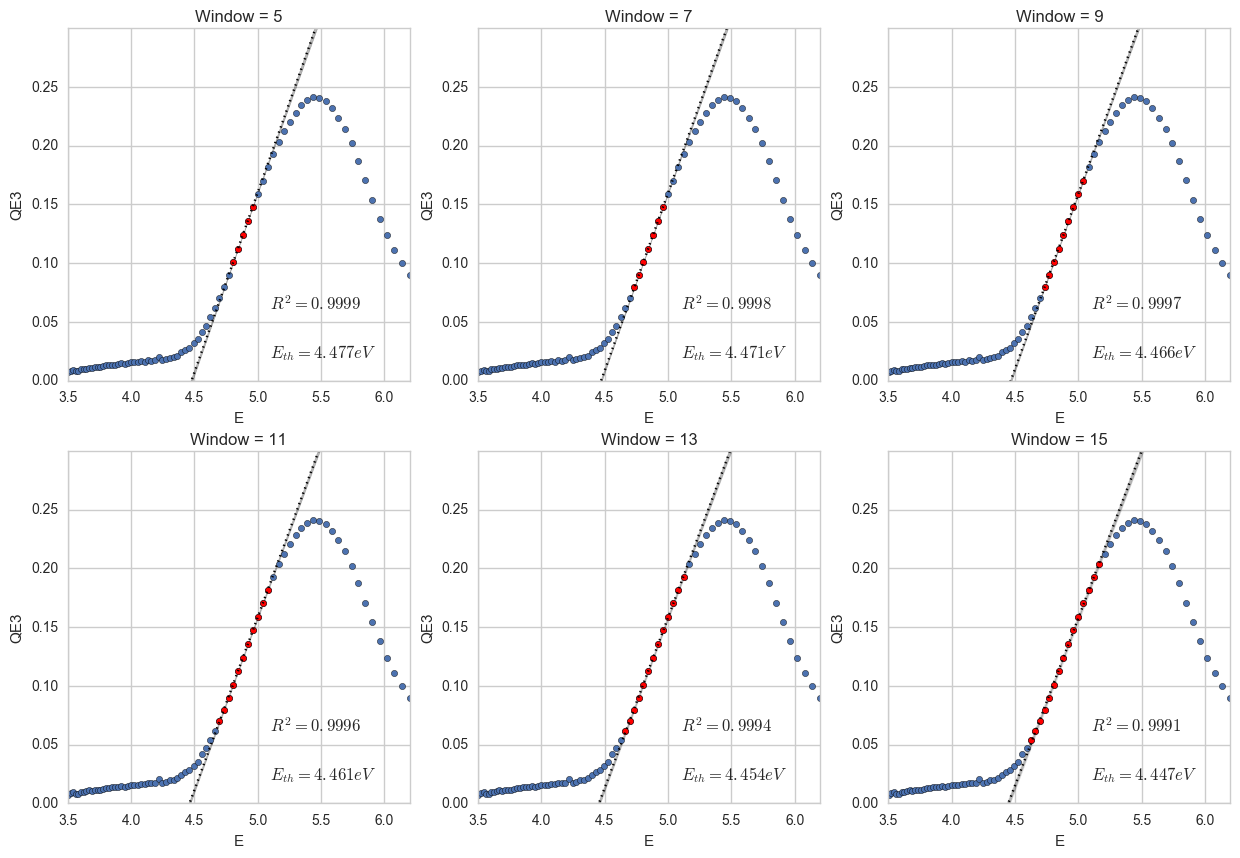

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for w, ax in zip([5, 7, 9, 11, 13, 15], list(itertools.chain(*axes))):
    f = find_linear(data, window_length=w)

    xp = np.arange(4, 6, 0.01)
    f.plot_fit(xp, ax)
    
    data.plot(x='E', y='QE3', kind='scatter', ax=ax, xlim=(3.5, 6.2), ylim=(0, 0.3))
    ax.scatter(f.x, f.y, c='r')

    ax.text(5.1, 0.061, r'$R^2 = {:.4}$'.format(f.rsquared))
    ax.text(5.1, 0.02, r'$E_{th}$' + r'$ = {:.4} eV$'.format(f.x_intercept))
    
    ax.set_title('Window = {}'.format(w))